### Pruebas subplots_gridspec

### 1.- Importación bibliotecas

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload

project_root = Path.cwd().parent  # estando en notebooks/
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import utils.visualizaciones as vis

# Recarga por si has tocado utils/visualizaciones.py
reload(vis)

<module 'utils.visualizaciones' from 'c:\\Users\\Ramón\\Desktop\\proyecto_comparativa_25_26\\utils\\visualizaciones.py'>

### 2.- Paleta de colores

In [3]:
# --------- PALETA "Neon Space" ----------
BG_MAIN       = "#0b0d2a"   # Fondo principal
BG_SECONDARY  = "#10223a"   # Fondo secundario
TEXT_MAIN     = "#e6edf3"   # Texto principal
TEXT_SECOND   = "#9da7b3"   # Texto secundario
TITLE_COLOR   = "#ff00b3"   # Magenta neón
ACCENT_CYAN   = "#00e5ff"   # Cian neón
ACCENT_GREEN  = "#39ff14"   # Verde neón
ACCENT_YELLOW = "#ffee00"   # Amarillo neón
GRID_COLOR    = "#2d333b"   # Bordes
PITCH_GREEN   = "#6125A9D9"   # Césped
PITCH_LINES   = "#e3fad5"   # Líneas campo

# --------- Estilo base ----------
plt.rcParams.update({
    "figure.facecolor": BG_MAIN,
    "axes.facecolor": BG_MAIN,
    "savefig.facecolor": BG_MAIN,
    "text.color": TEXT_MAIN,
    "axes.labelcolor": TEXT_MAIN,
    "xtick.color": TEXT_SECOND,
    "ytick.color": TEXT_SECOND,
    "axes.edgecolor": GRID_COLOR
})

### 3.- Funciones complementarias

In [4]:
def tidy_axes(ax, with_frame=True):
    """Quita ticks, deja (o no) el marco, y colorea spines."""
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(with_frame)
        spine.set_color(GRID_COLOR)
        spine.set_linewidth(1)

def place_image(ax, path):
    """Mete una imagen ocupando el eje, manteniendo marco."""
    try:
        img = mpimg.imread(path)
        ax.imshow(img, interpolation="bilinear")
        ax.set_aspect("equal")
        ax.set_xlim(0, img.shape[1]); ax.set_ylim(img.shape[0], 0)
        ax.margins(x=0, y=0)     # elimina márgenes internos del eje
        ax.set_anchor('C')       # evita que el aspect ratio desplace la imagen

    except FileNotFoundError:
        ax.text(0.5, 0.5, "imagen no encontrada", ha="center", va="center", fontsize=9, color=TEXT_SECOND)
    tidy_axes(ax, with_frame=True)

def draw_green_pitch(ax, title=None):
    """Dibuja el campo con fondo verde césped."""
    vis.draw_opta_pitch(ax, pitch_color=PITCH_GREEN, line_color=PITCH_LINES, linewidth=0.9)
    ax.set_facecolor(PITCH_GREEN)  # seguridad extra
    if title:
        ax.set_title(title, fontsize=12, fontweight="bold", color=ACCENT_CYAN)
    tidy_axes(ax, with_frame=True)

### 4.- Selección métricas

In [6]:
# --- Parámetros y helpers (NO dibuja nada) ---

SELECTED_POSITION = "mc"  # ej.: "centrales","laterales","mc","extremos","delanteros","porteros"

# Usa tus IDs WhoScored del master que pasaste
PLAYER_IDS = [484451, 484453, 489407]  # Aitana, Alexia, Patri (ajusta el orden si quieres)

# Rutas (ajústalas a tu estructura)
PATH_MASTER_PLAYERS = "../data/masters/master_jugadores.csv"   # con playerID, name, team, etc.
# (Si de momento solo quieres tirar de master, no necesitas cargar WhoScored/FBref aquí)

METRICS_BY_POSITION = {
    "mc": [
        ("Pases clave",        ["KeyPasses","Pases_clave","passing_KP"]),
        ("Pases prog/90",      ["ProgPassesPer90","Pases_Progresivos","stats_PrgP"]),
        ("xA",                 ["xA","passing_xA"])
    ],
    # añade el resto si quieres…
}

def load_master(path):
    # Detecta separador de forma simple y lee el CSV
    import io
    with open(path, "r", encoding="utf-8") as f:
        first = f.readline()
    sep = ";" if (";" in first and "," not in first) else ","
    m = pd.read_csv(path, sep=sep, encoding="utf-8")
    m.columns = [c.strip() for c in m.columns]
    return m


def pick_metric(row, candidates, default=np.nan):
    for c in candidates:
        if c in row.index and pd.notna(row[c]):
            return row[c]
    return default

def _col(df, options):
    """Devuelve el primer nombre de columna que exista en df."""
    for c in options:
        if c in df.columns:
            return c
    return None

def build_profiles(player_ids, selected_position):
    m = load_master(PATH_MASTER_PLAYERS)

    # Resolver nombres de columnas con flexibilidad
    col_id   = _col(m, ["playerID","playerId","player_id","id"])
    col_name = _col(m, ["name","nick_name","name_ws","nameWS"])
    col_team = _col(m, ["team","teamName","Squad","Equipo"])
    col_pos  = _col(m, ["position","pos","Pos"])
    col_nat  = _col(m, ["nacionalidad","Nation","Nacionalidad"])
    col_foto = _col(m, ["foto_path","foto","image_path"])

    if col_id is None:
        raise ValueError(f"No encuentro columna de ID en master. Tengo: {list(m.columns)}")

    # Filtrar en el orden de player_ids
    # (por si el master trae IDs como str)
    ids_series = m[col_id].astype(str)
    wanted     = set(map(str, player_ids))
    sel = m[ids_series.isin(wanted)].copy()

    # Ordenar igual que PLAYER_IDS
    sel["__order"] = pd.Categorical(ids_series[sel.index], categories=list(map(str, player_ids)), ordered=True)
    sel = sel.sort_values("__order").drop(columns="__order")

    profiles = []
    metrics_cfg = METRICS_BY_POSITION.get(selected_position, [])
    for _, r in sel.iterrows():
        p = {
            "playerId": r[col_id],
            "nombre":   r.get(col_name),
            "club":     r.get(col_team),
            "pos":      r.get(col_pos),
            "nac":      r.get(col_nat),
            "foto":     f"../data/{r.get(col_foto)}" if (col_foto and isinstance(r.get(col_foto), str)) else None,
            "edad":     None,
            "minutos":  None,
        }
        for etiqueta, posibles in metrics_cfg:
            p[etiqueta] = pick_metric(r, posibles)
        profiles.append(p)

    # Si por lo que sea falta alguno, avisamos
    if len(profiles) != len(player_ids):
        faltan = [pid for pid in player_ids if str(pid) not in set(ids_series.astype(str))]
        print(f"⚠️ No encontré en master estos IDs: {faltan}")
    return profiles

def paint_basic_stats(ax, profile, title_color="#00e5ff"):
    """Pinta nombre como título y 3-5 líneas con info básica + métricas."""
    ax.set_title(profile.get("nombre", "Jugador"), fontsize=12, weight="bold", color=title_color)
    lines = [
        f"Club: {profile.get('club','')}",
        f"Posición: {profile.get('pos','')}",
        f"Nacionalidad: {profile.get('nac','')}",
    ]
    if profile.get("edad") is not None:
        lines.append(f"Edad: {profile['edad']}")
    if profile.get("minutos") is not None:
        lines.append(f"Minutos: {profile['minutos']}")

    # métricas configuradas para la posición
    for etiqueta, _ in METRICS_BY_POSITION.get(SELECTED_POSITION, []):
        val = profile.get(etiqueta)
        if isinstance(val, (int, float, np.floating)):
            val = f"{val:.2f}"
        lines.append(f"{etiqueta}: {'' if val is None else val}")

    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", fontsize=10)
    # deja el marco y sin ticks (tu helper tidy_axes ya los quita en la celda 3)

# Ejecuta y deja ‘profiles’ listo para usar en la Celda 5
profiles = build_profiles(PLAYER_IDS, SELECTED_POSITION)


### 5.- Función de despliegue

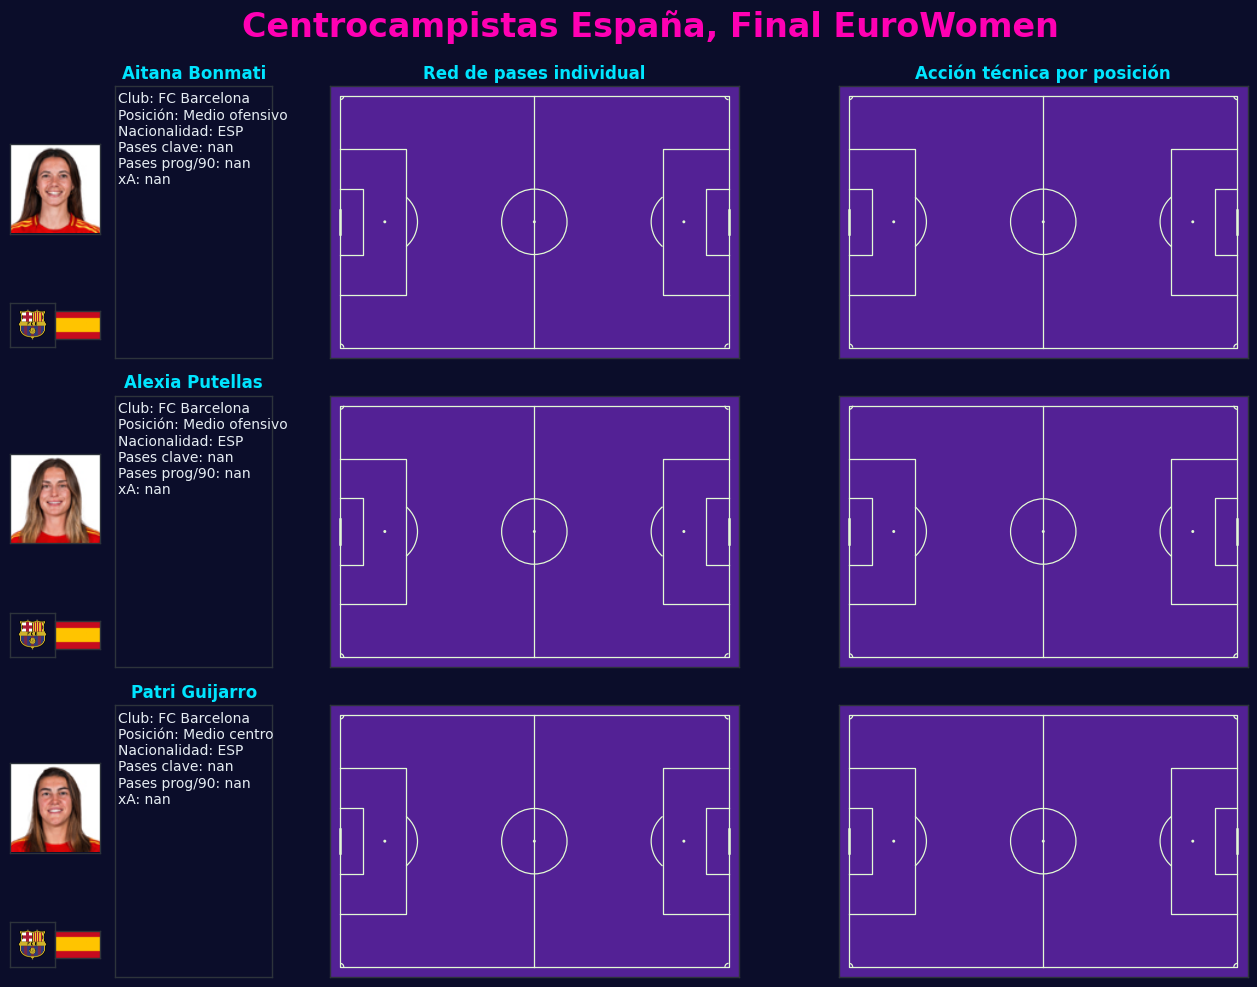

In [11]:
# --------- FIGURA & GRID ---------
fig = plt.figure(figsize=(16, 11))
gs  = fig.add_gridspec(3, 4, width_ratios=[0.40, 0.70, 2.20, 2.20], wspace=0.05, hspace=0.14)

# Col 0: Foto (arriba) + Escudo+Bandera (abajo)
ax_foto, ax_escudo, ax_flag = [], [], []
for r in range(3):
    gcol0 = gs[r, 0].subgridspec(2, 1, height_ratios=[0.76, 0.24], hspace=0.01)
    ax_foto.append(fig.add_subplot(gcol0[0, 0]))
    # abajo: 1x2 (escudo | bandera)
    gbadge = gcol0[1, 0].subgridspec(1, 2, width_ratios=[1, 1], wspace=0.015)
    ax_escudo.append(fig.add_subplot(gbadge[0, 0]))
    ax_flag.append(fig.add_subplot(gbadge[0, 1]))
    tidy_axes(ax_foto[-1], False); tidy_axes(ax_escudo[-1], False); tidy_axes(ax_flag[-1], False)

# Col 1: Stats (vacío de momento, con marco)
ax_stats = [fig.add_subplot(gs[r, 1]) for r in range(3)]
for ax in ax_stats:
    tidy_axes(ax, with_frame=True)

# Col 2: Redes de pase (3) con campo
ax_red = [fig.add_subplot(gs[r, 2]) for r in range(3)]
for i, ax in enumerate(ax_red):
    draw_green_pitch(ax, title="Red de pases individual" if i == 0 else None)

# Col 3: Redes de pase (3) con campo
ax_accion = [fig.add_subplot(gs[r, 3]) for r in range(3)]
for i, ax in enumerate(ax_accion):
    draw_green_pitch(ax, title="Acción técnica por posición" if i == 0 else None)

# Título global
fig.suptitle("Centrocampistas España, Final EuroWomen", fontsize=24, fontweight="bold", color=TITLE_COLOR, y=0.99, ha="center")
plt.subplots_adjust(top=0.92, left=0.10)

# --------- Colocar imágenes ----------
players = [
    "../images/players/bonmati.png",
    "../images/players/putellas.png",
    "../images/players/guijarro.png",
]
logos = [
    "../images/logos/fcb.png",
    "../images/logos/fcb.png",
    "../images/logos/fcb.png",
]
flags = [
    "../images/flags/esp.png",
    "../images/flags/esp.png",
    "../images/flags/esp.png",
]

for i in range(3):
    place_image(ax_foto[i],   players[i])
    place_image(ax_escudo[i], logos[i])
    place_image(ax_flag[i],   flags[i])

# --- PINTAR STATS EN ax_stats ---
for i, p in enumerate(profiles):
    paint_basic_stats(ax_stats[i], p)
plt.draw()


plt.show()

### Prueba de formato distinto

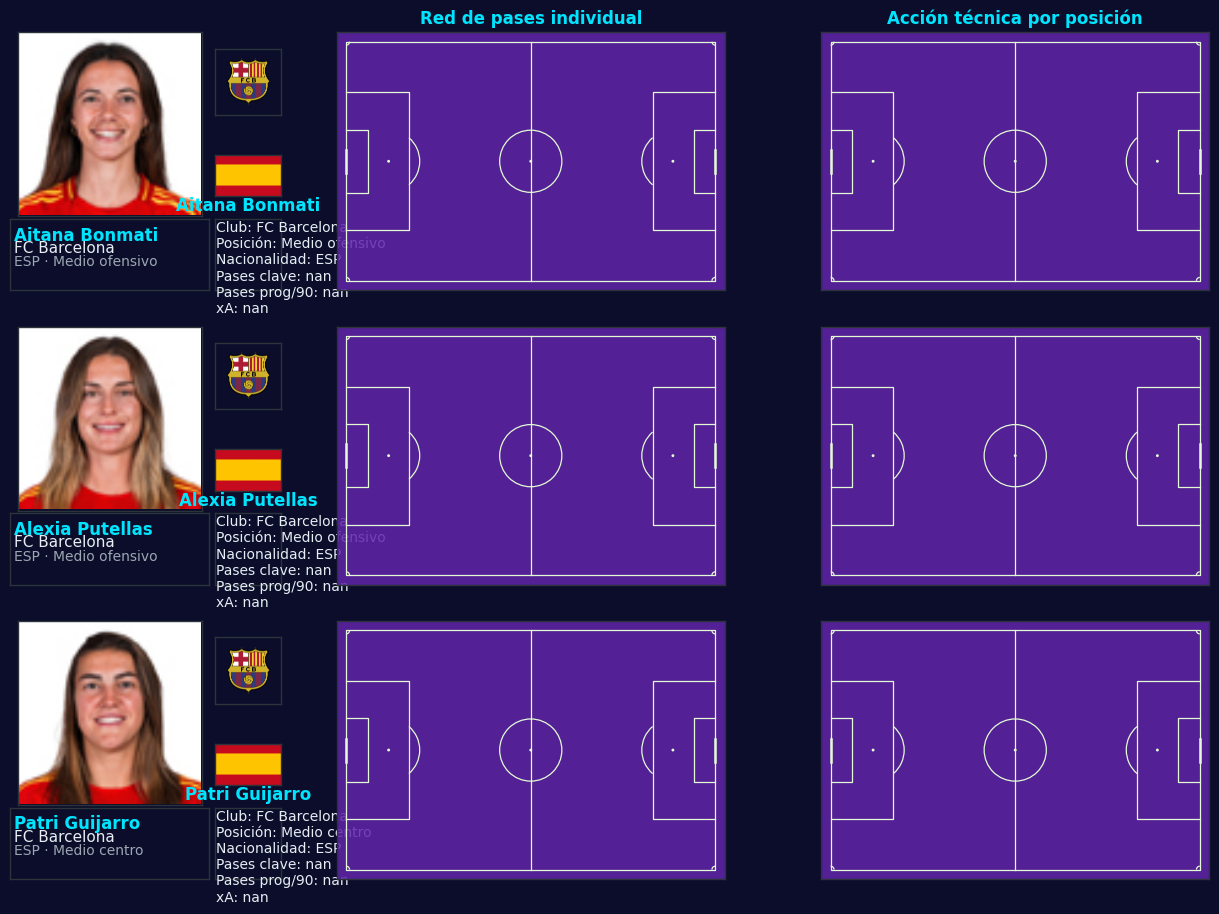

In [7]:
# --------- FIGURA & GRID ---------
fig = plt.figure(figsize=(16, 11))
gs  = fig.add_gridspec(3, 4, width_ratios=[0.50, 0.70, 2.20, 2.20], wspace=0.05, hspace=0.14)

# --- NUEVO BLOQUE: layout 2x2 por fila que abarca columnas 0 y 1 ---
ax_foto, ax_escudo, ax_flag, ax_ident, ax_stats = [], [], [], [], []
for r in range(3):
    # este subgrid ocupa las columnas 0 y 1 de la fila r
    area = gs[r, 0:2].subgridspec(
        2, 2, 
        height_ratios=[0.72, 0.28],  # fila superior (medios) / inferior (textos)
        width_ratios=[0.75, 0.25],   # izquierda (principal) / derecha (estrecha)
        hspace=0.02, wspace=0.04
    )

    # Fila superior: FOTO (izda)  |  (ESCUDO / BANDERA) (dcha, en 2 filas)
    ax_f = fig.add_subplot(area[0, 0])
    side  = area[0, 1].subgridspec(2, 1, height_ratios=[0.55, 0.45], hspace=0.04)
    ax_e = fig.add_subplot(side[0, 0])
    ax_b = fig.add_subplot(side[1, 0])

    # Fila inferior: IDENTIDAD (izda) | STATS (dcha)
    ax_i = fig.add_subplot(area[1, 0])
    ax_s = fig.add_subplot(area[1, 1])

    # estilos (sin marco en escudo/bandera; con marco en el resto)
    tidy_axes(ax_f, True)
    tidy_axes(ax_e, False); ax_e.set_facecolor("none")
    tidy_axes(ax_b, False); ax_b.set_facecolor("none")
    tidy_axes(ax_i, True)
    tidy_axes(ax_s, True)

    ax_foto.append(ax_f); ax_escudo.append(ax_e); ax_flag.append(ax_b)
    ax_ident.append(ax_i); ax_stats.append(ax_s)

# --- Col 2: Redes de pase (igual que ya tenías) ---
ax_red = [fig.add_subplot(gs[r, 2]) for r in range(3)]
for i, ax in enumerate(ax_red):
    draw_green_pitch(ax, title="Red de pases individual" if i == 0 else None)

# --- Col 3: Acción técnica (igual que ya tenías) ---
ax_accion = [fig.add_subplot(gs[r, 3]) for r in range(3)]
for i, ax in enumerate(ax_accion):
    draw_green_pitch(ax, title="Acción técnica por posición" if i == 0 else None)

for i in range(3):
    place_image(ax_foto[i],   players[i])
    place_image(ax_escudo[i], logos[i])
    place_image(ax_flag[i],   flags[i])

for i, p in enumerate(profiles):
    # nombre + club centrado debajo de la foto
    ax_ident[i].text(0.02, 0.90, p.get("nombre",""),  ha="left", va="top",
                     fontsize=12, fontweight="bold", color=ACCENT_CYAN, transform=ax_ident[i].transAxes)
    ax_ident[i].text(0.02, 0.70, p.get("club",""),    ha="left", va="top",
                     fontsize=11, color=TEXT_MAIN, transform=ax_ident[i].transAxes)
    ax_ident[i].text(0.02, 0.50, f"{p.get('nac','')} · {p.get('pos','')}", ha="left", va="top",
                     fontsize=10, color=TEXT_SECOND, transform=ax_ident[i].transAxes)


for i, p in enumerate(profiles):
    paint_basic_stats(ax_stats[i], p)   # aquí dejas solo las métricas del partido

